In [516]:
import numpy as np
from matplotlib import pyplot as plt
import qutip as qip
from qutip import sigmaz, sigmax, sigmay, qeye, tensor, fock_dm, Qobj, expect, basis, ket2dm
from qutip.qip.operations import gates

$$ H = \omega_L \sum_i^N I^{(i)}_z + \sum_i^N \left( A^{(i)}_{zz} S_z I^{(i)}_{z}  + A^{(i)}_{zx} S_zI^{(i)}_{x} \right) $$

In [517]:
sz = tensor(sigmaz()*0.5, qeye(2))

In [518]:
iz = tensor(qeye(2), sigmaz()*0.5)
ix = tensor(qeye(2), sigmax()*0.5)

In [549]:
# sz.ptrace(0)

In [519]:
pi_half_x_e = gates.rotation(op=sigmax(), phi=np.pi/2.0, N=2, target=0)
pi_half_y_e = gates.rotation(op=sigmay(), phi=np.pi/2.0, N=2, target=0)
pi_x_e = gates.rotation(op=sigmax(), phi=np.pi, N=2,target=0)

In [563]:
class e_spin_with_nuclear_spins:
    def __init__(self, A_zz, A_zx, B, N):
        self.A_zz = A_zz #list
        self.A_zx = A_zx #list
        self.B = B
        self.N = N
        self.init_H()
    def init_H(self):
        self.H = []
        gamma_n = 10.7*1e-4 # MHz/G
        for a_zz, a_zx in zip(self.A_zz, self.A_zx):
            self.H.append(
                 iz*gamma_n*self.B + sz*iz*a_zz + sz*ix* a_zx
            )  
    
    def evolve_i(self, rho, seq, i):        
        rho1 = rho
        for s in seq:
            if isinstance(s, Qobj):
                rho1 = s*rho1*s.dag()
            elif isinstance(s, float):
                U = (self.H[i]*1j*s).expm()
                rho1 = U*rho1*U.dag()
            elif isinstance(s, dict):#tensor(sigmaz(),qeye(2))
                out = mesolve(rho0=rho1, H=self.H, c_ops=[tensor(sigmaz(),qeye(2))], tlist=np.linspace(0, s['T_c'], 10), 
                          options = Options(nsteps=1e5))
                return out.states[-1]                
        return rho1
    
    def experiment(self, seq, **kwargs):
        Pi = 1
        rho = tensor(fock_dm(2,0), qeye(2)*0.5)
        for i, _ in enumerate(self.A_zz):
            rho1 = self.evolve_i(rho, seq(**kwargs),i)
            p0 = expect(sigmaz(), rho1.ptrace(0))
            Pi *= p0
        return Pi

    def sequence(self,tau):
        
        seq = [pi_half_y_e]
        seq += [tau, pi_x_e, tau] * self.N
        seq += [pi_half_y_e.dag()]

        return seq

In [584]:
A_zz = 2 * np.pi * np.array([213.154, -36.308, 20.569]) * 1e-3
A_zx =  2 * np.pi * np.array([3.0, 26.62, 41.51]) * 1e-3

B = 300
N = 32

In [585]:
e_spin = e_spin_with_nuclear_spins(A_zz=A_zz, A_zx=A_zx, B=B, N=N)

In [586]:
Phe = []
taus = np.linspace(0,30,300)
for tau in taus:
    Phe.append(e_spin.experiment(seq=e_spin.sequence, tau=tau))

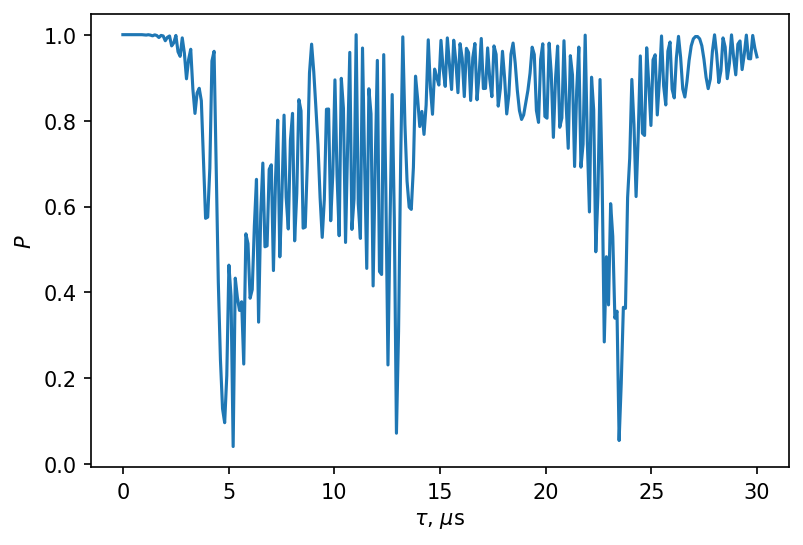

In [587]:
plt.figure(dpi=150)

plt.plot(taus, 0.5 * (1 + np.array(Phe)))
# plt.ylim((0.5, 1.1))
plt.xlabel('$\\tau$, $\mu$s')
plt.ylabel('$P$')
plt.savefig('DD_seq.png')